# Predicting Critical Temperature of Superconductors

### Daniel Connolly

Data Science Spring 2019

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

Using TensorFlow backend.


I import the data, which was provided in csv format by the UCI Machine Learning repository.

In [2]:
train = pd.read_csv('train.csv')
chems = pd.read_csv('unique_m.csv')

In [3]:
train.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [4]:
chems.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [5]:
df_std = train.copy()

Standardize the columns to avoid placing too much weight on any single feature.

In [6]:
def std_cols(df):
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())/df[col].std()
    return df

In [7]:
std_cols(df_std)
df_std.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,-0.080056,0.046732,-0.451640,-0.158846,-0.611805,0.044357,-0.003707,0.133722,-0.053037,0.378177,...,-0.752138,-0.805893,-0.711688,0.186288,0.035182,-0.837939,-0.406157,-0.838353,-0.520057,-0.158264
1,0.614729,0.174265,-0.432061,0.059367,-0.604166,0.777412,-0.015267,0.133722,0.108898,0.134898,...,-0.752138,-1.116705,-0.719437,0.664955,-0.014779,-0.033010,-0.362343,-0.426856,-0.450811,-0.245844
2,-0.080056,0.046732,-0.450967,-0.158846,-0.611644,0.044357,-0.218978,0.133722,0.093292,0.378177,...,-0.740146,-0.805893,-0.700712,0.186288,-0.062233,-0.837939,-0.376948,-0.838353,-0.503292,-0.450197
3,-0.080056,0.046732,-0.451304,-0.158846,-0.611724,0.044357,-0.103613,0.133722,0.020127,0.378177,...,-0.746142,-0.805893,-0.706208,0.186288,-0.010537,-0.837939,-0.391552,-0.838353,-0.511512,-0.362617
4,-0.080056,0.046732,-0.452314,-0.158846,-0.611966,0.044357,0.162771,0.133722,-0.199367,0.378177,...,-0.764131,-0.805893,-0.722601,0.186288,0.113625,-0.837939,-0.435366,-0.838353,-0.538165,-0.333424


Break the data up into training and test sets. We are trying to predict the critical temperature, so we have create a separate dataframe containing only that column from the original data as the output of our system.

In [8]:
y = df_std['critical_temp']
X = df_std.drop('critical_temp', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

Create a Keras neural network with two hidden layers that will try to find the critical temperature.

In [9]:
n_cols = X.shape[1]
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
17010/17010 [==============================] - 1s 36us/step - loss: 0.2510


With a loss of 0.249, this model does not seem to perform particularly well.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               8200      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 18,401
Trainable params: 18,401
Non-trainable params: 0
_________________________________________________________________


In [11]:
predictions = model.predict(X_test)

In [12]:
predictions

array([[-0.77009016],
       [ 1.419061  ],
       [ 0.69575197],
       ...,
       [-0.9497979 ],
       [-0.7588753 ],
       [-0.6411552 ]], dtype=float32)

In [13]:
def mse(pred, true):
    mse = np.zeros(len(pred))
    for i in range(len(pred)):
        mse[i] = (np.mean((true.values[i] - pred[i][0])**2))
    mean = mse.mean()
    return mse, mean

In [14]:
error, mean_error = mse(predictions, y_test)
error, mean_error

(array([2.29857235e-03, 5.68834679e-02, 3.49606504e-01, ...,
        2.21874794e-03, 6.37834061e-05, 9.05710206e-02]), 0.18002846784181495)

Yup, this model does not seem to work particularly well. Let's try a random forest model.

In [15]:
regr = RandomForestRegressor(max_depth=2,random_state=0,n_estimators=100)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
imp = regr.feature_importances_

In [17]:
def get_feats(df, importance):
    ll = dict()
    for i in range(len(df.columns)-1):
        if (importance[i] > 0):
            ll[df.columns[i]] = importance[i]
    return ll

In [18]:
get_feats(df_std, imp)

{'mean_Density': 0.013091539375679426,
 'gmean_Density': 0.000820364280821392,
 'wtd_gmean_ThermalConductivity': 0.18320716285975705,
 'range_ThermalConductivity': 0.8028809334837423}

The random forest model suggests that only four variables actually matter, and those four can be further reduced to two main concepts: Density and Thermal Conductivity. Based on these results, Density and Thermal Conductivity contain nearly all of the predictive power of the variables we were provided. Given that critical temperature is a measure of the temperature at which a material becomes a superconductor, the fact that thermal conductivity has predictive power is not particularly suprising.

Below, while perhaps poor form, I use the unstandardized data. I do this because I had originally run this test (Lasso Regression) without standardizing the data and found notable features, but found no useful results with the standardized data. As a result, since I am still exploring which features in the dataset really matter, I felt it important to mention the finding that atomic mass and radius may also have some amount of predictive power.

In [19]:
y = train['critical_temp']
X = train.drop('critical_temp', axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [21]:
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
lasso_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)

0.3932948395099838

In [23]:
coef = lasso.coef_

In [24]:
names = X_train.columns

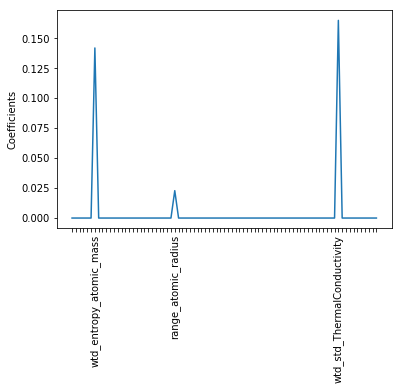

In [25]:
plt.plot(range(len(X_train.columns)), coef)
count = dict()
for i in range(len(coef)):
    if coef[i] > 0.02:
        count[i] = names[i]
    else:
        count[i] = ''

plt.xticks(range(len(count.keys())), count.values(), rotation=90)
plt.ylabel('Coefficients')
plt.show()

It's immediately apparent that atomic mass, atomic radius, and thermal conductivity contribute the most to the critical temperature. However, our model scored only 39%, so obviously there is more to the story.

In [26]:
param_grid = {'alpha': np.arange(0.1,1,50)}

In [27]:
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid, cv=5)
lasso_cv.fit(X, y)
lasso_cv.best_params_

/home/dconnolly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dconnolly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dconnolly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/dconnolly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objectiv

{'alpha': 0.1}

In [28]:
lasso_cv.best_score_

0.3163159081822262

Let's look into how the chemical composition affects the critical temperature now.

In [29]:
chems.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [30]:
def std_chem_cols(df):
    for col in df.columns:
        if (col != 'material'):
            df[col] = (df[col] - df[col].mean())/df[col].std()
    return df

In [31]:
chems = std_chem_cols(chems)
chems.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,-0.06618,NaN,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,NaN,...,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,NaN,NaN,NaN,-0.158264,Ba0.2La1.8Cu1O4
1,-0.06618,NaN,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,NaN,...,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,NaN,NaN,NaN,-0.245844,Ba0.1La1.9Ag0.1Cu0.9O4
2,-0.06618,NaN,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,NaN,...,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,NaN,NaN,NaN,-0.450197,Ba0.1La1.9Cu1O4
3,-0.06618,NaN,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,NaN,...,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,NaN,NaN,NaN,-0.362617,Ba0.15La1.85Cu1O4
4,-0.06618,NaN,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,NaN,...,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,NaN,NaN,NaN,-0.333424,Ba0.3La1.7Cu1O4


In [32]:
def remove_nan(df):
    cols = list()
    for col in df.columns:
        if (df[col].sum() == 0.0):
            cols.append(col)
    return df.drop(columns=cols, axis=1)

In [33]:
chems = remove_nan(chems)
chems.head()

,H,Li,Be,B,C,N,O,F,Na,Mg,...,Re,Os,Ir,Au,Hg,Tl,Pb,Bi,critical_temp,material
0,-0.06618,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,-0.087444,-0.098568,...,-0.032448,-0.079754,-0.071177,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,-0.158264,Ba0.2La1.8Cu1O4
1,-0.06618,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,-0.087444,-0.098568,...,-0.032448,-0.079754,-0.071177,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,-0.245844,Ba0.1La1.9Ag0.1Cu0.9O4
2,-0.06618,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,-0.087444,-0.098568,...,-0.032448,-0.079754,-0.071177,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,-0.450197,Ba0.1La1.9Cu1O4
3,-0.06618,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,-0.087444,-0.098568,...,-0.032448,-0.079754,-0.071177,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,-0.362617,Ba0.15La1.85Cu1O4
4,-0.06618,-0.09359,-0.040821,-0.136521,-0.087333,-0.08831,0.259959,-0.112582,-0.087444,-0.098568,...,-0.032448,-0.079754,-0.071177,-0.028601,-0.178111,-0.176109,-0.15476,-0.30645,-0.333424,Ba0.3La1.7Cu1O4


In [34]:
y,X = chems['critical_temp'], chems.drop(['critical_temp','material'], axis=1)
regr = RandomForestRegressor(max_depth=2,random_state=0,n_estimators=100)
regr.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [35]:
def get_chem_feats(df, importance):
    ll = dict()
    diff = len(df.columns) - len(importance)
    for i in range(len(df.columns)-diff):
        if (importance[i] > 0):
            ll[df.columns[i]] = importance[i]
    return ll

In [36]:
imp = regr.feature_importances_
get_chem_feats(chems, imp)

{'O': 0.034349245096133116,
 'Ca': 0.061597954245700394,
 'Cu': 0.8945941363993106,
 'Ba': 0.009458664258855505}

Copper seems to play a major role in determining the critical temperature of superconductors. I suppose this means copper is in most superconductors?

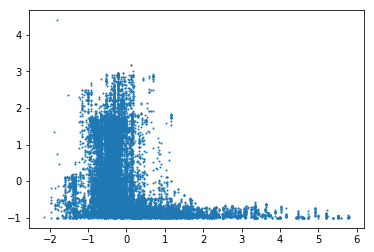

In [37]:
plt.plot(df_std['mean_Density'], df_std['critical_temp'], 'o', markersize=1)

The above looks like a skewed Gaussian distribution to me.

/home/dconnolly/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


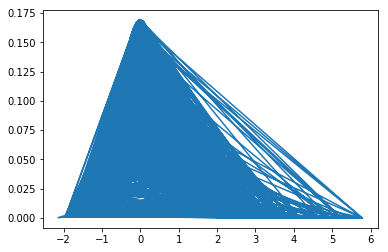

In [38]:
from scipy.optimize import curve_fit
mean, var = df_std['mean_Density'].mean(), df_std['mean_Density'].std()**2

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

coeff, var_mat = curve_fit(gauss,df_std['mean_Density'],df_std['critical_temp'],p0=[1,mean,var])
hist_fit = gauss(df_std['mean_Density'], *coeff)
plt.plot(df_std['mean_Density'], hist_fit, label='Fitted data')


# x, y = np.random.multivariate_normal(mean, var, size=50).T
# ax = sns.kdeplot(x)


I still need to get the above plot to work.